In [1]:
from __future__ import print_function
import os
import sys

sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], "src"))

from pkg.utils.test_scripts import *
from pkg.planning.pddlstream.plan_rnb import *

rtype = "panda"
dat_root = "stowing-deep"
res_root = "stowing-deep-result-btf-ik08-to2.0"
dat_dir = "20210917-113211"
VISUALIZE = True
PLAY_RESULT = True

TOOL_NAME="grip0"
ROBOT_TYPE = {e.name: e for e in RobotType}[rtype]

########################################################
################### Create data folders ################
DATASET_PATH = create_data_dirs(dat_root, rtype, dat_dir)
RESULTSET_PATH = create_data_dirs(res_root, rtype, dat_dir)
print("-"*50)
print("DATASET_PATH: {}".format(DATASET_PATH))
print("RESULTSET_PATH: {}".format(RESULTSET_PATH))
print("-"*50)

########################################################
########## Load scene and prepare planner  #############
ROBOT_NAME, TOOL_LINK, TOOL_XYZ, TOOL_RPY, HOME_POSE, GRIP_DEPTH = get_single_robot_params(ROBOT_TYPE)
s_builder, pscene = prepare_single_robot_scene(ROBOT_TYPE, ROBOT_NAME, TOOL_LINK, TOOL_XYZ, TOOL_RPY, VISUALIZE=VISUALIZE)
crob, gscene = pscene.combined_robot, pscene.gscene

--------------------------------------------------
DATASET_PATH: /home/rnb/Projects/rnb-planning/data/stowing-deep/panda/20210917-113211
RESULTSET_PATH: /home/rnb/Projects/rnb-planning/data/stowing-deep-result-btf-ik08-to2.0/panda/20210917-113211
--------------------------------------------------
connection command:
panda0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## load scene

In [2]:
file_option = "obj_3c_obs7"
data_idx = 1

In [3]:
fname = "data_%s_%02d.pkl" % (file_option, data_idx)
file_gtems = os.path.join(DATASET_PATH, fname)
try:
    initial_state = load_saved_scene(pscene, file_gtems, VISUALIZE=VISUALIZE)
except:
    pass
gscene.NAME_DICT['obj_0'].color = (1,0,0,1)
gscene.update_markers_all()

## play plan

In [14]:
cname = "Full"

In [19]:
sample = load_pickle(os.path.join(RESULTSET_PATH, "result_%s_%02d_%s.pkl" % (file_option, data_idx, cname)))

res = sample["success"]
plan = sample["plan"]
body_names = sample["body_names"]

if res:
    for action in plan:
        print(action)

    if VISUALIZE and PLAY_RESULT and res:
        play_pddl_plan(pscene, pscene.actor_dict["grip0"], initial_state=initial_state,
                       body_names=body_names, plan=plan, SHOW_PERIOD=0.05)


Action(name='move_free', args=(q0, q1, c4))
Action(name='pick', args=(2L, p2, g3, q1, c0))
Action(name='move_holding', args=(q1, q3, 2L, g3, c5))
Action(name='place', args=(2L, p8, g3, q3, c2))
Action(name='move_free', args=(q3, q0, c3))


## Loop

In [5]:
file_options = ["obj_1c_obs0", "obj_1c_obs3", "obj_1c_obs5", "obj_1c_obs7", "obj_3c_obs3", "obj_3c_obs5", "obj_3c_obs7"]

In [22]:
for file_option in file_options[-1:]:
    N_tests = 50
    len_list = []

    for data_idx in range(N_tests):
        lens = []
        for cname in ["None", "Tool", "ToolReach", "Full"]:
            sample = load_pickle(os.path.join(RESULTSET_PATH, "result_%s_%02d_%s.pkl" % (file_option, data_idx, cname)))
            plan = sample['plan']
            if plan is None:
                continue
            traj_all = []
            for act in plan:
                if "move" in act.name:
                    bp =act.args[-1].body_paths[0]
                    traj_all+=list(bp.path)
            traj_all = np.array(traj_all)
            lens.append(np.sum(np.linalg.norm(differentiate(traj_all, 1), axis=-1)))
        if len(lens) == 4:
            len_list.append(lens)
        else:
            len_list.append([0]*4)

    minlen_list = np.min(len_list, axis=-1)
    idc_longer = np.argsort(-minlen_list)
    
    for data_idx in idc_longer[:10]:
        data_idx += 1

        sample = load_pickle(os.path.join(RESULTSET_PATH, "result_%s_%02d_%s.pkl" % (file_option, data_idx, cname)))

        res = sample["success"]
        plan = sample["plan"]
        body_names = sample["body_names"]

        if not res: continue
            
        pscene.clear_subjects()

        fname = "data_%s_%02d.pkl" % (file_option, data_idx)
        file_gtems = os.path.join(DATASET_PATH, fname)
        try:
            initial_state = load_saved_scene(pscene, file_gtems, VISUALIZE=VISUALIZE)
        except:
            pass
        gscene.NAME_DICT['obj_0'].color = (1,0,0,1)
        for gtem in gscene:
            if "obs" in gtem.name:
                gtem.color = (0.5,0.5,0.5,0.3)
            if "floor" in gtem.name:
                gtem.color = (0.8,0.8,0.8,1.0)
        gscene.update_markers_all()

        for action in plan:
            print(action)
        time.sleep(10)

        if VISUALIZE and PLAY_RESULT and res:
            play_pddl_plan(pscene, pscene.actor_dict["grip0"], initial_state=initial_state,
                           body_names=body_names, plan=plan, SHOW_PERIOD=0.05)


Action(name='move_free', args=(q0, q1, c10))
Action(name='pick', args=(2L, p2, g2, q1, c0))
Action(name='move_holding', args=(q1, q9, 2L, g2, c11))
Action(name='place', args=(2L, p15, g2, q9, c8))
Action(name='move_free', args=(q9, q0, c9))
Action(name='move_free', args=(q0, q5, c6))
Action(name='pick', args=(2L, p2, g5, q5, c4))
Action(name='move_holding', args=(q5, q4, 2L, g5, c7))
Action(name='place', args=(2L, p10, g5, q4, c3))
Action(name='move_free', args=(q4, q0, c5))
Action(name='move_free', args=(q0, q6, c7))
Action(name='pick', args=(2L, p2, g8, q6, c5))
Action(name='move_holding', args=(q6, q5, 2L, g8, c8))
Action(name='place', args=(2L, p3, g8, q5, c4))
Action(name='move_free', args=(q5, q0, c6))
Action(name='move_free', args=(q0, q1, c2))
Action(name='pick', args=(2L, p2, g0, q1, c0))
Action(name='move_holding', args=(q1, q3, 2L, g0, c6))
Action(name='place', args=(2L, p4, g0, q3, c4))
Action(name='move_free', args=(q3, q0, c5))
Action(name='move_free', args=(q0, q3, c8))


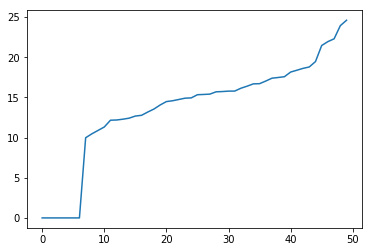

In [71]:
import matplotlib.pyplot as plt
plt.plot(sorted(minlen_list))

In [49]:
traj_all

[array([ 0.        , -0.3       ,  0.        , -0.5       ,  0.        ,
         2.5       ,  1.57079633]),
 array([ 3.20885174e-02, -3.13031595e-01,  1.59469703e-03, -5.30155430e-01,
        -3.54312042e-02,  2.50098317e+00,  1.52768658e+00]),
 array([ 0.06417703, -0.32606319,  0.00318939, -0.56031086, -0.07086241,
         2.50196634,  1.48457682]),
 array([ 0.09626555, -0.33909479,  0.00478409, -0.59046629, -0.10629361,
         2.50294951,  1.44146707]),
 array([ 0.12835407, -0.35212638,  0.00637879, -0.62062172, -0.14172482,
         2.50393268,  1.39835732]),
 array([ 0.16044259, -0.36515798,  0.00797349, -0.65077715, -0.17715602,
         2.50491585,  1.35524757]),
 array([ 0.1925311 , -0.37818957,  0.00956818, -0.68093258, -0.21258723,
         2.50589902,  1.31213782]),
 array([ 0.22461962, -0.39122117,  0.01116288, -0.71108801, -0.24801843,
         2.50688219,  1.26902807]),
 array([ 0.25670814, -0.40425276,  0.01275758, -0.74124344, -0.28344963,
         2.50786536,  1.225

## shutdown rviz

In [ ]:

s_builder.xcustom.clear()